In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()
print('Tensorflow version: %s' % str(tf.__version__))

Tensorflow version: 2.0.0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import sys
import os
if sys.platform.startswith('darwin'):
    print('Enable multiple instances of OpenMP on macOS')
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Enable multiple instances of OpenMP on macOS


In [4]:
print('Prepare fashion dataset')
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print('shape of training data %s' % str(train_images.shape))

Prepare fashion dataset
shape of training data (60000, 28, 28)


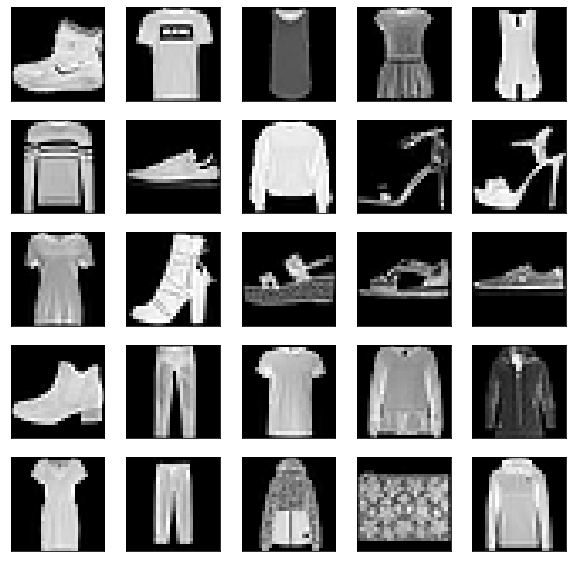

In [5]:
train_images = train_images/255.0
test_images = test_images/255.0

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.gray)
    plt.xlabel(class_names[train_labels[i]], color='white')
plt.show()

In [6]:
print('Prepare model')
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Prepare model


In [7]:
print('Train the model')
for i in range(100):
    print('Epoch {}'.format(i+1))
    model.fit(train_images, train_labels)
    train_loss, train_acc = model.evaluate(train_images, train_labels, verbose=2)
    if train_acc > 0.9:
        print('Reach required accuracy 0.9')
        break

Train the model
Epoch 1
Train on 60000 samples
60000/60000 [==============================] - 9s 156us/sample - loss: 0.4996 - accuracy: 0.8232
60000/1 - 3s - loss: 0.3502 - accuracy: 0.8676
Epoch 2
Train on 60000 samples
60000/60000 [==============================] - 8s 133us/sample - loss: 0.3788 - accuracy: 0.8640
60000/1 - 3s - loss: 0.3182 - accuracy: 0.8717
Epoch 3
Train on 60000 samples
60000/60000 [==============================] - 8s 140us/sample - loss: 0.3379 - accuracy: 0.8750
60000/1 - 3s - loss: 0.2838 - accuracy: 0.8867
Epoch 4
Train on 60000 samples
60000/60000 [==============================] - 10s 169us/sample - loss: 0.3132 - accuracy: 0.8839
60000/1 - 4s - loss: 0.2607 - accuracy: 0.8845
Epoch 5
Train on 60000 samples
60000/60000 [==============================] - 9s 155us/sample - loss: 0.2958 - accuracy: 0.8913
60000/1 - 3s - loss: 0.2644 - accuracy: 0.8959
Epoch 6
Train on 60000 samples
60000/60000 [==============================] - 10s 159us/sample - loss: 0.280

In [8]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', test_acc)

10000/1 - 1s - loss: 0.2537 - accuracy: 0.8838
Test accuracy: 0.8838


In [9]:
print('Prepare probability model by using softmax as output layer')
probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])

Prepare probability model by using softmax as output layer


In [10]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


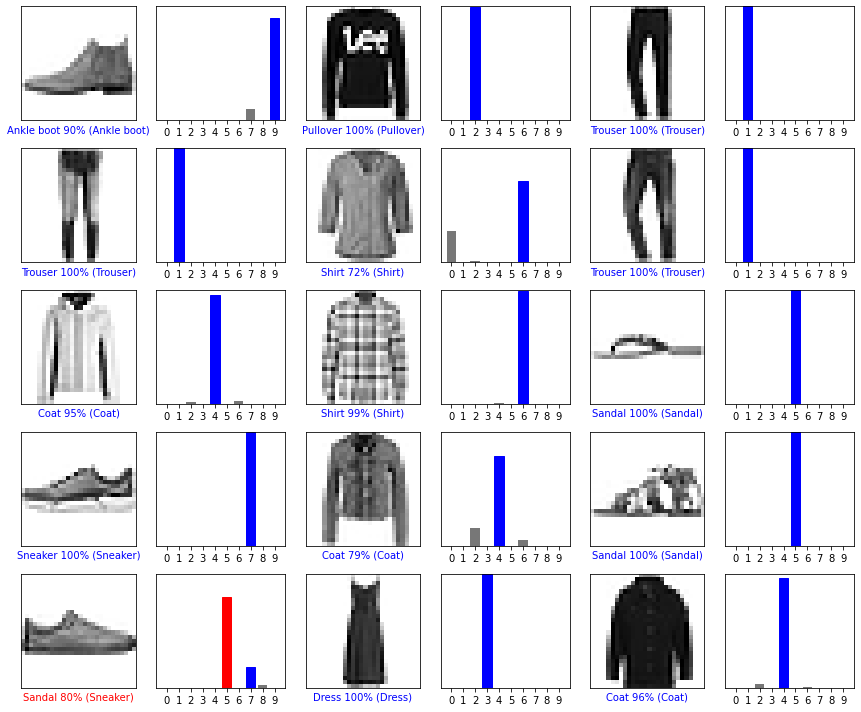

In [11]:
predictions = probability_model.predict(test_images)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [12]:
print('Try out keras tuner')

import kerastuner as kt
print('Keras tuner version: {}'.format(kt.__version__))

Try out keras tuner
Keras tuner version: 1.0.1


In [13]:
print('Prepare model builder according to hyper parameters')
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    hp_layers = hp.Int('layers', min_value = 1, max_value = 3, step = 1)
    for i in range(hp_layers):
        model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(tf.keras.layers.Dense(10))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                  metrics = ['accuracy'])

    return model

Prepare model builder according to hyper parameters


In [14]:
print('Prepare tuner')
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tunner',
                     project_name = 'fashion')

Prepare tuner
INFO:tensorflow:Reloading Oracle from existing project fasion/tuner_fashion/oracle.json
INFO:tensorflow:Reloading Tuner from fasion/tuner_fashion/tuner0.json


In [15]:
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(train_images, train_labels, epochs = 10, validation_data = (test_images, test_labels),
            callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.
Count of layers is {best_hps.get('layers')}.
The optimal number of units in the hidden layers is {best_hps.get('units')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
Count of layers is 2.
The optimal number of units in the hidden layers is 352.
The optimal learning rate is 0.001.



In [16]:
tuned_model = model_builder(best_hps)
tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 352)               276320    
_________________________________________________________________
dense_3 (Dense)              (None, 352)               124256    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                3530      
Total params: 404,106
Trainable params: 404,106
Non-trainable params: 0
_________________________________________________________________


In [19]:
print('Train the turned model')
for i in range(100):
    print('Epoch {}'.format(i+1))
    tuned_model.fit(train_images, train_labels, verbose=2)
    train_loss, train_acc = tuned_model.evaluate(train_images, train_labels, verbose=2)
    if train_acc > 0.9:
        print('Reach required accuracy 0.9')
        break

Train the turned model
Epoch 1
Train on 60000 samples
60000/60000 - 18s - loss: 0.3325 - accuracy: 0.8762
60000/1 - 4s - loss: 0.2784 - accuracy: 0.8845
Epoch 2
Train on 60000 samples
60000/60000 - 19s - loss: 0.3034 - accuracy: 0.8863
60000/1 - 4s - loss: 0.2501 - accuracy: 0.8918
Epoch 3
Train on 60000 samples
60000/60000 - 18s - loss: 0.2859 - accuracy: 0.8922
60000/1 - 5s - loss: 0.2334 - accuracy: 0.8966
Epoch 4
Train on 60000 samples
60000/60000 - 21s - loss: 0.2700 - accuracy: 0.8983
60000/1 - 4s - loss: 0.2353 - accuracy: 0.9036
Reach required accuracy 0.9


In [20]:
tuned_test_loss, tuned_test_acc = tuned_model.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy of tuned model:', tuned_test_acc)

10000/1 - 1s - loss: 0.2419 - accuracy: 0.8727
Test accuracy of tuned model: 0.8727
